#  Обнаружение объектов


In [ ]:
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch
import zipfile

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
extracted_dir = '/content/animals.zip'

In [ ]:
archive = zipfile.ZipFile('/content/animals.zip', 'r')
archive.extractall()

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
def parse_xml(file):
      tree = ET.parse(file)
      root = tree.getroot()
      obj = root.find('object')
      bndbox = obj.find('bndbox')
      raw = {
          'xmin': float(bndbox.find('xmin').text),
          'ymin': float(bndbox.find('ymin').text),
          'xmax': float(bndbox.find('xmax').text),
          'ymax': float(bndbox.find('ymax').text)
      }
      size = root.find('size')
      width = float(size.find('width').text)
      height = float(size.find('height').text)
      scaled = {
          'xmin': raw['xmin'] / width,
          'ymin': raw['ymin'] / height,
          'xmax': raw['xmax'] / width,
          'ymax': raw['ymax'] / height
      }
      obj_data = {
          'raw': raw,
          'scaled': scaled,
          'obj_name': obj.find('name').text
      }
      return obj_data

In [ ]:
parse_xml('/content/Asirra: cat vs dogs/dog.56.xml')

{'raw': {'xmin': 53.984875202178955,
  'ymin': 36.07916581630707,
  'xmax': 406.483717918396,
  'ymax': 499.0},
 'scaled': {'xmin': 0.10972535610198975,
  'ymin': 0.0723029375076294,
  'xmax': 0.8261864185333252,
  'ymax': 1.0},
 'obj_name': 'dog'}

<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.ops.boxes import nms

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, return_scaled=True, target_transform = None, cvat = False):
        self.root_dir = root
        self.transform = transforms
        self.target_transform = target_transform
        self.return_raw_coords = return_scaled
        self.cvat = cvat
        self.samples = []  # Список пар (изображение, аннотация)
        self.load_data()
        self.class_map = {}

    def load_data(self):
        for filename in os.listdir(self.root_dir):
            if filename.endswith('.jpg'):
                img_path = os.path.join(self.root_dir, filename)
                xml_filename = filename.replace('.jpg', '.xml')
                xml_path = os.path.join(self.root_dir, xml_filename)

                if os.path.exists(xml_path):
                  if self.cvat:
                    annotation = parse_xml_cvat(xml_path)
                    self.samples.append((img_path, annotation))
                  else:
                    annotation = parse_xml(xml_path)
                    self.samples.append((img_path, annotation))



    def __getitem__(self, index):
        img_path, annotation = self.samples[index]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        #image_tensor = torch.ToTensor()(image)
        #image_tensor = image_tensor.permute(1, 2, 0)
        raw_coords = annotation['raw']
        scaled_coords = annotation['scaled']
        if self.return_raw_coords:
            coords = scaled_coords
        else:
            coords = raw_coords

        coords = torch.tensor([coords['xmin'], coords['ymin'], coords['xmax'], coords['ymax']])

        label = annotation['obj_name']
        if self.target_transform:
            label = self.target_transform(label)

        return image, coords, label, img_path

    def __len__(self):
        return len(self.samples)

In [ ]:
AnimalDetectionDataset('/content/Asirra: cat vs dogs')

<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [ ]:
label_map = {'cat': 0, 'dog': 1}
target_transform = lambda label: label_map[label]

data = AnimalDetectionDataset('/content/Asirra: cat vs dogs', return_scaled=False, target_transform=target_transform)

In [ ]:
data[0]

(tensor([[[0.2000, 0.1686, 0.1451,  ..., 0.8863, 0.8863, 0.8980],
          [0.2353, 0.2196, 0.1176,  ..., 0.8588, 0.8471, 0.8588],
          [0.2667, 0.2157, 0.0314,  ..., 0.8784, 0.8667, 0.8863],
          ...,
          [0.2275, 0.2745, 0.2863,  ..., 0.6667, 0.4980, 0.5373],
          [0.2667, 0.2667, 0.2510,  ..., 0.6510, 0.5333, 0.5882],
          [0.2784, 0.2275, 0.1961,  ..., 0.5804, 0.5294, 0.6118]],
 
         [[0.3804, 0.3412, 0.3098,  ..., 0.9569, 0.9569, 0.9686],
          [0.4157, 0.3922, 0.2745,  ..., 0.9294, 0.9176, 0.9294],
          [0.4431, 0.3922, 0.1882,  ..., 0.9412, 0.9255, 0.9490],
          ...,
          [0.1961, 0.2431, 0.2353,  ..., 0.7922, 0.6314, 0.6784],
          [0.2353, 0.2353, 0.2000,  ..., 0.7765, 0.6667, 0.7294],
          [0.2471, 0.1961, 0.1451,  ..., 0.7059, 0.6627, 0.7529]],
 
         [[0.4745, 0.4392, 0.4078,  ..., 0.9725, 0.9725, 0.9843],
          [0.5098, 0.4902, 0.3765,  ..., 0.9373, 0.9333, 0.9373],
          [0.5333, 0.4824, 0.2863,  ...,

In [ ]:
import cv2
import matplotlib.pyplot as plt

def show_image_with_bounding_box(dataset, index, figsize=(8, 8), image_permute = False):
    image, coords, obj_name, imape_path = dataset[index]
    fig, ax = plt.subplots(figsize=figsize)
    if isinstance(obj_name, int):
      class_map = {0: 'cat', 1: 'dog'}
      obj_name = class_map[int(obj_name)]
    if image_permute:
      image = image.permute(1, 2, 0)
    ax.imshow(image)

    xmin = coords[0]
    xmax = coords[2]
    ymax = coords[3]
    ymin = coords[1]
    width = xmax - xmin
    height = ymax - ymin

    # Рисуем прямоугольник
    rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

    # Добавляем подпись
    ax.text(xmin, ymin - 15, obj_name, color='white', backgroundcolor='red')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

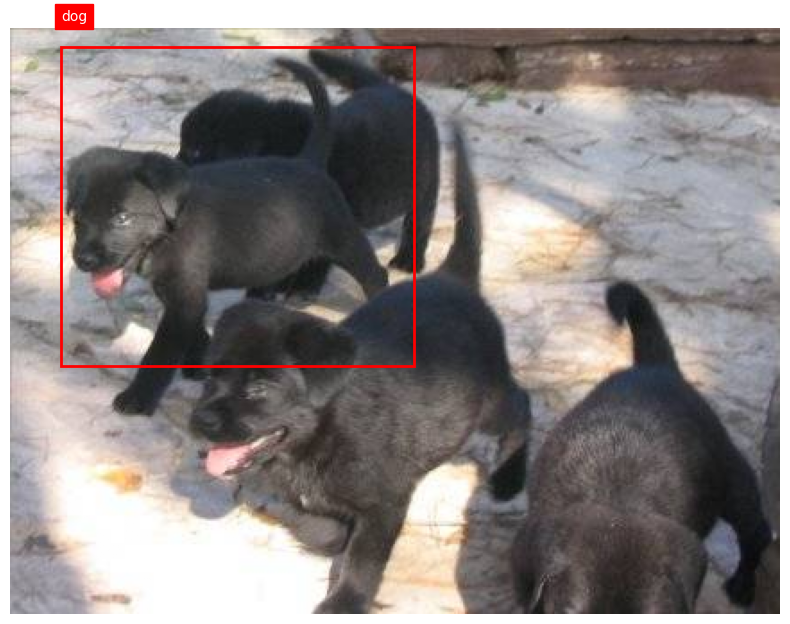

In [ ]:
show_image_with_bounding_box(data, 5, image_permute = True)

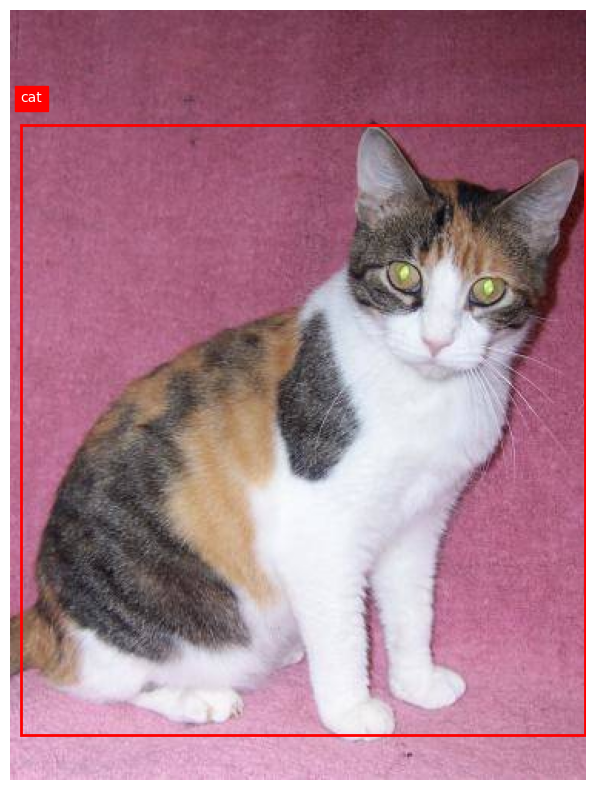

In [ ]:
show_image_with_bounding_box(data, 1000, image_permute = True)

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
class ImprovedObjectDetector(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Загружаем предобученную модель ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)

        # Удаляем последнюю линейную классификационную голову
        modules = list(self.backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*modules)

        # Определяем голову для классификации
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes)
        )

        # Определяем голову для регрессии bounding box
        self.bbox_regressor = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)

        cls_logits = self.classifier(features)
        bbox_preds = self.bbox_regressor(features)

        return cls_logits, bbox_preds

In [ ]:
class ImprovedObjectDetector(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Загружаем предобученную модель ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)

        # Удаляем последнюю линейную классификационную голову
        modules = list(self.backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*modules)

        # Определяем голову для классификации
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes)  # Используем num_classes
        )

        # Определяем голову для регрессии bounding box
        self.bbox_regressor = nn.Sequential(
            nn.Linear(2048, 512),
            #nn.BatchNorm1d(512),  # Добавляем нормализацию
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            #nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            #nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)

        cls_logits = self.classifier(features)
        bbox_preds = self.bbox_regressor(features)

        return cls_logits, bbox_preds

<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn

In [ ]:
def compute_loss(pred_cls_logits, pred_bboxes, gt_labels, gt_bboxes):
    criterion_cls = nn.CrossEntropyLoss()
    criterion_reg = nn.MSELoss()

    loss_cls = criterion_cls(pred_cls_logits, gt_labels.long())
    loss_reg = criterion_reg(pred_bboxes, gt_bboxes.float())

    total_loss = loss_cls + loss_reg

    return total_loss

In [ ]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(predictions, true_labels):
    predictions = torch.argmax(predictions, dim=1).detach().cpu().numpy()
    true_labels = true_labels.detach().cpu().numpy()
    return accuracy_score(true_labels, predictions)

In [ ]:
from sklearn.metrics import fbeta_score

def calculate_f2_score(predictions, true_labels, beta=2):
    predictions = torch.argmax(predictions, dim=1).detach().cpu().numpy()
    true_labels = true_labels.detach().cpu().numpy()
    return fbeta_score(true_labels, predictions, beta=beta)

In [ ]:
from torch.utils.data import random_split
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

label_map = {'cat': 0, 'dog': 1}
target_transform = lambda label: label_map[label]


dataset = AnimalDetectionDataset(root='/content/Asirra: cat vs dogs', transforms=train_transforms, target_transform = target_transform)

# Разделение на обучающий и валидационный наборы
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создание DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size = 16, shuffle=False)

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=10):
    best_val_loss = float("inf")
    best_model_state_dict = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Обучающая фаза
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0
        running_train_f2 = 0.0
        for images, targets, labels, _ in train_loader:
            optimizer.zero_grad()

            cls_logits, bbox_preds = model(images)
            loss = compute_loss(cls_logits, bbox_preds, labels, targets)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            running_train_acc += calculate_accuracy(cls_logits, labels) * images.size(0)
            running_train_f2 += calculate_f2_score(cls_logits, labels) * images.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = running_train_acc / len(train_loader.dataset)
        epoch_train_f2 = running_train_f2 / len(train_loader.dataset)
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Train F2: {epoch_train_f2:.4f}')

        # Валидационная фаза
        with torch.no_grad():
            model.eval()
            running_val_loss = 0.0
            running_val_acc = 0.0
            running_val_f2 = 0.0
            for images, targets, labels, _ in val_loader:
                cls_logits, bbox_preds = model(images)
                loss = compute_loss(cls_logits, bbox_preds, labels, targets)

                running_val_loss += loss.item() * images.size(0)
                running_val_acc += calculate_accuracy(cls_logits, labels) * images.size(0)
                running_val_f2 += calculate_f2_score(cls_logits, labels) * images.size(0)

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            epoch_val_acc = running_val_acc / len(val_loader.dataset)
            epoch_val_f2 = running_val_f2 / len(val_loader.dataset)
            print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val F2: {epoch_val_f2:.4f}')

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state_dict = model.state_dict()

        scheduler.step(epoch_val_loss)

    print(f'Model trained. Best Val Loss: {best_val_loss:.4f}.')
    model.load_state_dict(best_model_state_dict)
    return model

In [ ]:
def freeze_backbone_layers(model):
    for param in model.backbone.parameters():
        param.requires_grad = False

In [ ]:
model = ImprovedObjectDetector(num_classes = 2)
freeze_backbone_layers(model)

# Оптимизация и планировщик скорости обучения
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Обучение модели
trained_model = train_model(model, optimizer, scheduler, num_epochs=8)

Epoch 1/8
------------------------------
Train Loss: 0.4322, Train Acc: 0.8398, Train F2: 0.8572
Val Loss: 0.1533, Val Acc: 0.9682, Val F2: 0.9561
Epoch 2/8
------------------------------
Train Loss: 0.1682, Train Acc: 0.9477, Train F2: 0.9520
Val Loss: 0.0962, Val Acc: 0.9818, Val F2: 0.9854
Epoch 3/8
------------------------------
Train Loss: 0.1536, Train Acc: 0.9489, Train F2: 0.9533
Val Loss: 0.0829, Val Acc: 0.9864, Val F2: 0.9914
Epoch 4/8
------------------------------
Train Loss: 0.1195, Train Acc: 0.9580, Train F2: 0.9571
Val Loss: 0.0725, Val Acc: 0.9955, Val F2: 0.9980
Epoch 5/8
------------------------------
Train Loss: 0.1081, Train Acc: 0.9727, Train F2: 0.9747
Val Loss: 0.0713, Val Acc: 0.9909, Val F2: 0.9945
Epoch 6/8
------------------------------
Train Loss: 0.1034, Train Acc: 0.9705, Train F2: 0.9728
Val Loss: 0.0646, Val Acc: 0.9909, Val F2: 0.9945
Epoch 7/8
------------------------------
Train Loss: 0.0857, Train Acc: 0.9761, Train F2: 0.9784
Val Loss: 0.0591, Val

In [ ]:
import numpy as np

In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)

In [ ]:
def predict_and_show_bounding_boxes(model,index,data,val_loader, threshold=0.7, val=False):

    i = 0
    for images, targets, labels, image_path_ in val_loader:
      image = images[0]
      image_path = image_path_[0]
      i+=1
      if index == i:
        break

    for y in data:
      if y[3] == image_path:
        image_plot = y[0]

    # Делаем предсказание
    with torch.no_grad():
        model.eval()
        cls_logits, bbox_preds = model(image.unsqueeze(0))
        cls_logits = cls_logits.argmax().item()

    # Преобразуем предсказанные координаты обратно в исходный размер изображения
    channel, original_height, original_width= image_plot.shape
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = bbox_preds.squeeze().numpy()
    print(pred_xmin, pred_ymin, pred_xmax, pred_ymax)
    pred_xmin *= original_width
    pred_ymin *= original_height
    pred_xmax *= original_width
    pred_ymax *= original_height



    print(pred_xmin, pred_ymin, pred_xmax, pred_ymax)
    print(original_height, original_width)
    # Отображаем изображение с bounding box
    show_image_with_bounding_box([[image_plot, [pred_xmin, pred_ymin, pred_xmax, pred_ymax],cls_logits, image_path]], 0, figsize=(8, 8), image_permute = True)


39.095112428069115 21.56047085672617 288.47645777463913 232.15765088796616
247 327


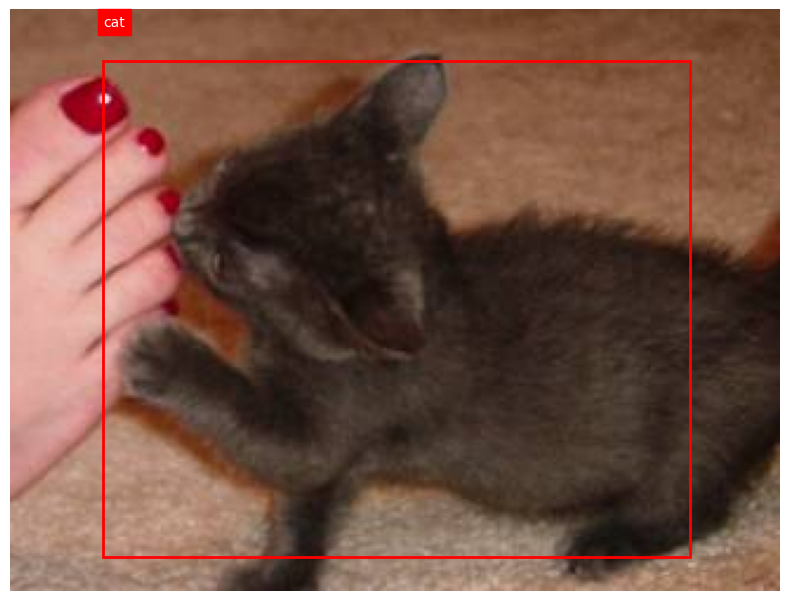

In [ ]:
predict_and_show_bounding_boxes(trained_model, 10, data, val_loader)

17.86435942351818 13.818795695900917 141.17527377605438 190.08201587200165
199 157


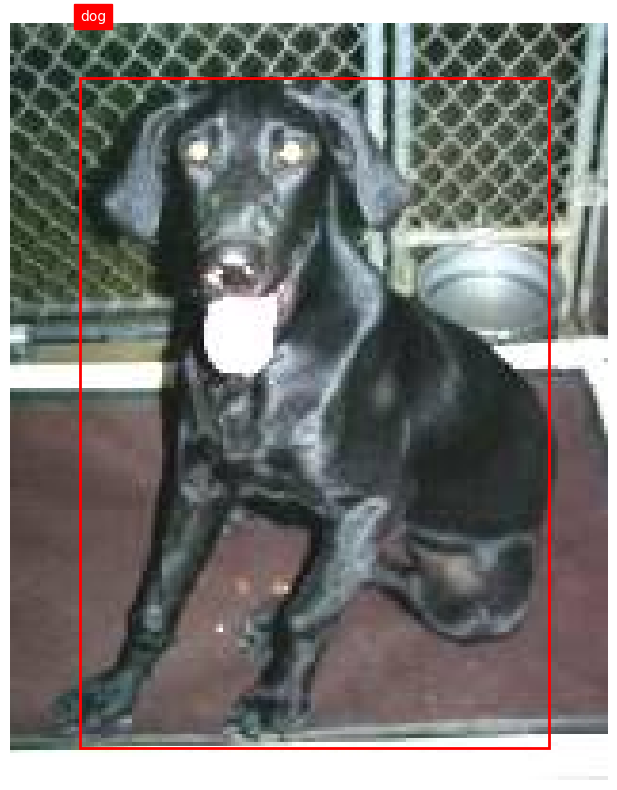

In [ ]:
predict_and_show_bounding_boxes(trained_model, 120, data, val_loader)

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

In [ ]:
def parse_xml_cvat(file):
    tree = ET.parse(file)
    root = tree.getroot()

    # Извлекаем информацию о картинке
    image_info = root.find('image')
    image_name = image_info.get('name')
    width = int(image_info.get('width'))
    height = int(image_info.get('height'))

    # Извлекаем все bounding box'ы для текущего изображения
    box = image_info.findall('box')[0]
    label = box.get('label')
    xtl = float(box.get('xtl'))  # xmin
    ytl = float(box.get('ytl'))  # ymin
    xbr = float(box.get('xbr'))  # xmax
    ybr = float(box.get('ybr'))  # ymax

    # Расчет нормализованных координат
    scaled = {
        'xmin': xtl / width,
        'ymin': ytl / height,
        'xmax': xbr / width,
        'ymax': ybr / height
    }

    # Формируем словарь для каждой аннотации
    annotation = {
        'image': image_name,
        'obj_name': label,
        'raw': {'xmin': xtl, 'ymin': ytl, 'xmax': xbr, 'ymax': ybr},
        'scaled': scaled
    }

    return annotation

In [ ]:
 data_new = AnimalDetectionDataset('/content/new', return_scaled=False, target_transform=target_transform,  cvat = True)

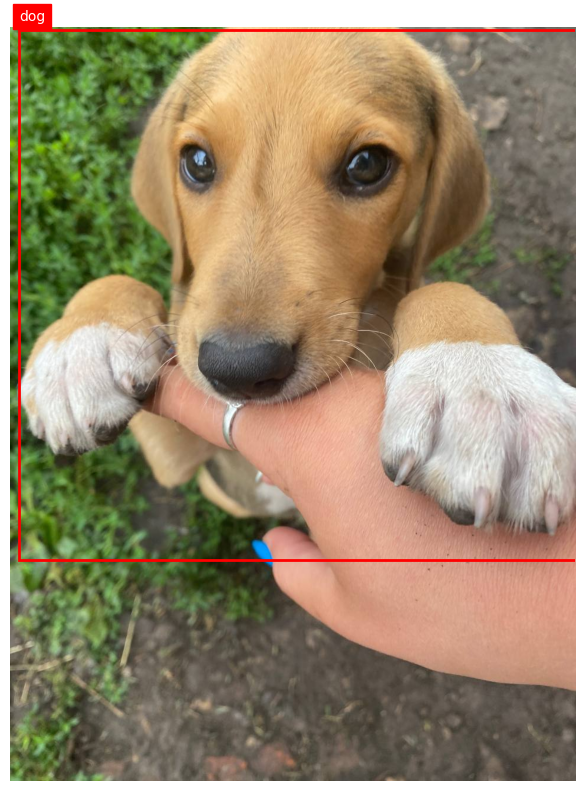

In [ ]:
show_image_with_bounding_box(data_new, 0, image_permute = True)

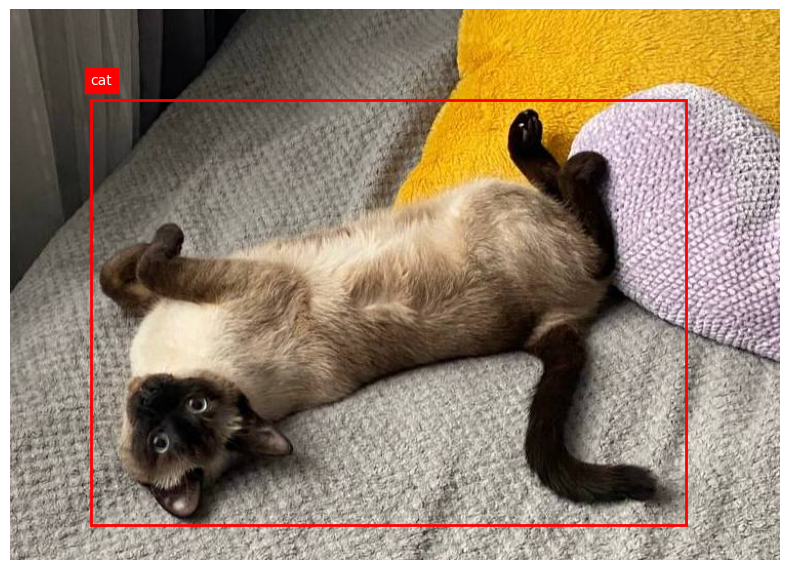

In [ ]:
show_image_with_bounding_box(data_new, 1, image_permute = True)

In [ ]:
data_new_tranform = AnimalDetectionDataset('/content/new', return_scaled=False, target_transform=target_transform, transforms = val_transforms, cvat = True)
test_loader = torch.utils.data.DataLoader(data_new_tranform, shuffle=False)

0.08310777 0.05036028 0.930262 0.9712804
62.413934886455536 27.04347090795636 698.6267839074135 521.5775726437569
537 751


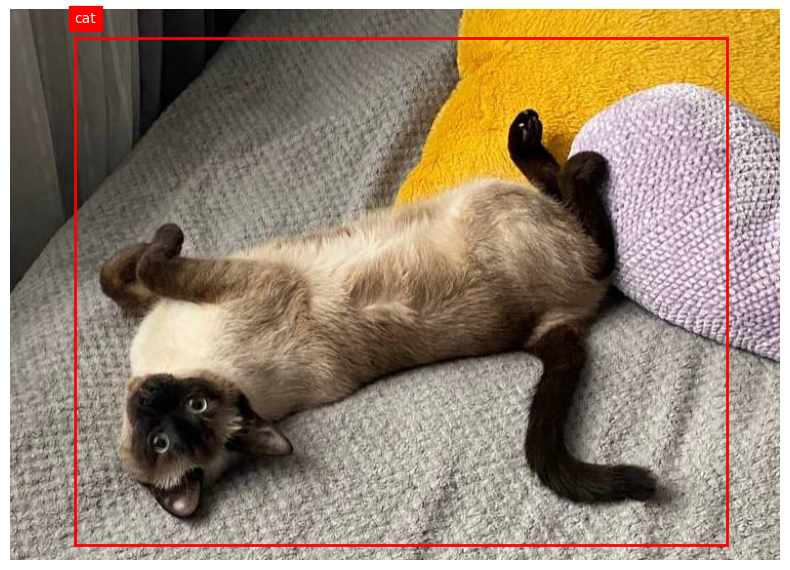

In [ ]:
predict_and_show_bounding_boxes(trained_model, 2,data_new,test_loader, threshold=0.7)

0.13369536 0.092905216 0.87834275 0.94044715
128.34754943847656 118.91867637634277 843.2090377807617 1203.7723541259766
1280 960


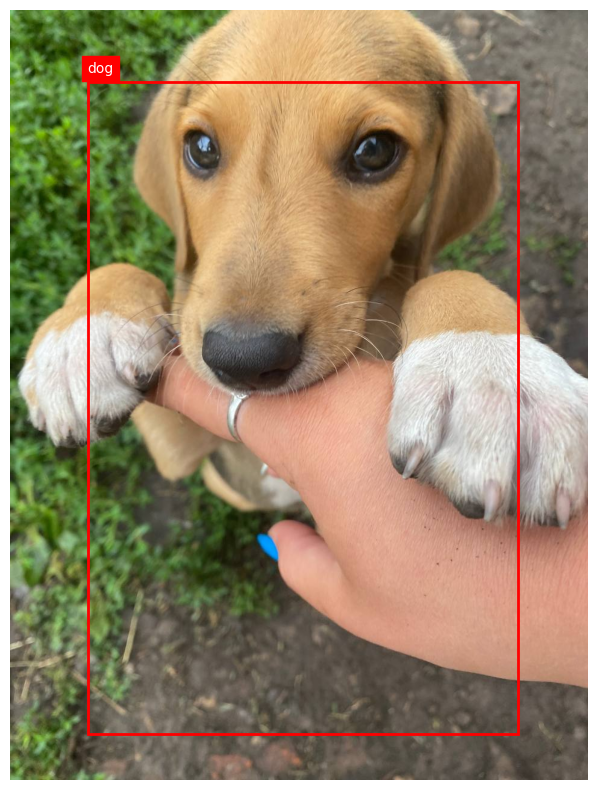

In [ ]:
predict_and_show_bounding_boxes(trained_model, 1,data_new,test_loader, threshold=0.7)

<p class="task" id="7"></p>

7*\. Повторите решение предыдущей задачи, используя модель `fasterrcnn_resnet50_fpn`. Замените слой для предсказания bounding box на `FastRCNNPredictor` с нужным количеством классов.

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, return_scaled=True, target_transform = None, cvat = False):
        self.root_dir = root
        self.transform = transforms
        self.target_transform = target_transform
        self.return_raw_coords = return_scaled
        self.cvat = cvat
        self.samples = []  # Список пар (изображение, аннотация)
        self.load_data()
        self.class_map = {}

    def load_data(self):
        for filename in os.listdir(self.root_dir):
            if filename.endswith('.jpg'):
                img_path = os.path.join(self.root_dir, filename)
                xml_filename = filename.replace('.jpg', '.xml')
                xml_path = os.path.join(self.root_dir, xml_filename)

                if os.path.exists(xml_path):
                  if self.cvat:
                    annotation = parse_xml_cvat(xml_path)
                    self.samples.append((img_path, annotation))
                  else:
                    annotation = parse_xml(xml_path)
                    self.samples.append((img_path, annotation))



    def __getitem__(self, index):
        img_path, annotation = self.samples[index]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        #image_tensor = torch.ToTensor()(image)
        #image_tensor = image_tensor.permute(1, 2, 0)
        raw_coords = annotation['raw']
        scaled_coords = annotation['scaled']
        if self.return_raw_coords:
            coords = scaled_coords
        else:
            coords = raw_coords

        coords = torch.tensor([coords['xmin'], coords['ymin'], coords['xmax'], coords['ymax']])

        label = annotation['obj_name']
        if self.target_transform:
            label = self.target_transform(label)

        target = {}
        target['boxes'] = coords
        target['labels'] = label

        return image, target

    def __len__(self):
        return len(self.samples)

In [ ]:
def create_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    for module in [model.roi_heads.box_predictor.cls_score, model.roi_heads.box_predictor.bbox_pred]:
        for param in module.parameters():
            param.requires_grad = True
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes*4)
    model.roi_heads.box_predictor.cls_score = nn.Linear(in_features, out_features=2, bias=True)
    return model

In [ ]:
model = create_model(num_classes=2, pretrained=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 216MB/s]


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

label_map = {'cat': 0, 'dog': 1}
target_transform = lambda label: label_map[label]


dataset = AnimalDetectionDataset(root='/content/Asirra: cat vs dogs', transforms=train_transforms, target_transform = target_transform)

# Разделение на обучающий и валидационный наборы
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создание DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size = 16, shuffle=False)

In [ ]:
for i, data in enumerate(train_loader):
  print(data[1]['boxes'][0])
  break

tensor([0.1261, 0.1059, 0.8747, 0.8998])


In [ ]:
def train(train_dataloader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image for image in images)
        targets_new = []
        for i in range(len(images)):
            d = {}
            d['boxes'] = targets['boxes'][i].unsqueeze(0)
            d['labels'] = targets['labels'][i].unsqueeze(0)
            targets_new.append(d)
        print(targets_new)
        loss_dict = model(images, targets_new)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image for image in images)
        targets_new = []
        for i in range(len(images)):
            d = {}
            d['boxes'] = targets['boxes'][i].unsqueeze(0)
            d['labels'] = targets['labels'][i].unsqueeze(0)
            targets_new.append(d)
        with torch.no_grad():
            loss_dict = model(images, targets_new)
        #loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss

In [ ]:
train_losses = []
val_losses = []
try:
    for epoch in range(10):
        start = time.time()
        train_loss = train(train_loader)
        val_loss = val(val_loader)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

[{'boxes': tensor([[0.0934, 0.0868, 0.9146, 0.9840]]), 'labels': tensor([1])}, {'boxes': tensor([[0.2685, 0.1263, 0.9547, 0.8863]]), 'labels': tensor([0])}, {'boxes': tensor([[0.1583, 0.0626, 0.9060, 0.9720]]), 'labels': tensor([0])}, {'boxes': tensor([[0.2010, 0.2725, 0.8166, 0.7134]]), 'labels': tensor([0])}, {'boxes': tensor([[0.0938, 0.0623, 0.7952, 0.9744]]), 'labels': tensor([0])}, {'boxes': tensor([[0.2369, 0.0137, 0.6001, 0.9022]]), 'labels': tensor([1])}, {'boxes': tensor([[0.1036, 0.0765, 0.9897, 1.0000]]), 'labels': tensor([0])}, {'boxes': tensor([[0.4572, 0.0613, 0.8637, 0.6636]]), 'labels': tensor([0])}, {'boxes': tensor([[0.0028, 0.0075, 0.9712, 0.9912]]), 'labels': tensor([0])}, {'boxes': tensor([[0.2031, 0.1482, 0.9219, 0.8768]]), 'labels': tensor([1])}, {'boxes': tensor([[0.0458, 0.0944, 0.9318, 0.8935]]), 'labels': tensor([0])}, {'boxes': tensor([[0.3082, 0.0443, 0.7274, 0.9422]]), 'labels': tensor([1])}, {'boxes': tensor([[0.1461, 0.1000, 1.0000, 1.0000]]), 'labels':